In [3]:
import pandas as pd

obj_tbl = pd.read_csv("../data/tables/Objects.csv.gz")
str_cols = "Title", "Description"
txts = [s for col in str_cols for s in obj_tbl[col].dropna()]

print("number of docs: ", len(txts))
tokens = [w for txt in txts for w in txt.split()]

print("number of tokens: ", len(tokens))
print("number of types: ", len(set(tokens)))
print("TTR: ", len(set(tokens))/len(tokens))

number of docs:  11199
number of tokens:  274580
number of types:  43518
TTR:  0.15848932915725836


In [4]:
NG3 = Ngram(3, documents=txts, padding=True, precompute_freqs=True)
NG2 = Ngram(2, documents=txts, padding=True, precompute_freqs=True)

(2, 3)-grams: Padding documents...: 100%|██████████| 11199/11199 [00:00<00:00, 950061.90it/s]


(2, 3)-grams: Term Document Matrix constructed...
(2, 3)-grams: Term frequencies precomputed...


(1, 2)-grams: Padding documents...: 100%|██████████| 11199/11199 [00:00<00:00, 1554026.68it/s]

(2, 3)-grams: Init done


(1, 2)-grams: Term Document Matrix constructed...
(1, 2)-grams: Term frequencies precomputed...
(1, 2)-grams: Init done


In [5]:
print(txts[1], NG3.sent_prob(txts[1], log=False))

for g in NG3.iter_ngrams(txts[1], 2):
    print(g, NG3.prob(*g.split()))

IJZEREN PORTEMONNAIE MET LONTARBLAADJES 8.92936869363336e-05
<s> ijzeren 0.0001008822313847876
ijzeren portemonnaie 3.254265528541536e-06
portemonnaie met 3.254265528541536e-06
met lontarblaadjes 3.254265528541536e-06
lontarblaadjes </s> 3.254265528541536e-06


In [6]:
s_pmis = {w.split()[1]: NG2.pmi(*w.split()) for w in NG2.vocab(2) if "<s>" in w}

In [7]:
pmis = {w: NG2.pmi(*w.split()) for w in tqdm(NG2.vocab(2))}

100%|██████████| 115726/115726 [00:01<00:00, 72867.41it/s]


In [8]:
pmis = [NG2.pmi(*w.split()) for t in tqdm(txts) for w in NG2.iter_ngrams(t, 2)]

100%|██████████| 11199/11199 [00:03<00:00, 3339.66it/s]


284891


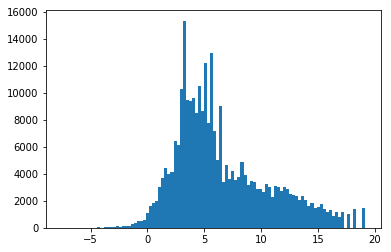

In [12]:
import matplotlib.pyplot as plt

print(len(pmis))
_ = plt.hist(pmis, bins=100)

In [10]:
NG2.save("test")

In [11]:
NG_ = Ngram.load("test")

[1, 2]-grams: Init done


---

In [1]:
from tqdm import tqdm

import numpy as np
import scipy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re

In [ ]:
# default_cv_params = dict(strip_accents="unicode", lowercase=True, 
#                                      max_df=1., min_df=0., max_features=None,
#                                      stop_words=None)
# default_cv_params["token_pattern"] = r"(?u)\b\w\w+\b|\<\/s\>|\<s\>" #if not "token_pattern" in count_vectoriser_args else count_vectoriser_args["token_pattern"]+r"|\<\/s\>|\<s\>"
        

# cv = CountVectorizer(ngram_range=(1,2), **default_cv_params)
# cv.build_analyzer()

# TODOs


features
 - stemming! spaCy's Dutch morphologizer perhaps
 - make PMI symmetric in its arguments (like its formal definition)? -> make that a choice, by adding a paramter to the functions
 
bugs
 - analyzer will need to be saved

In [2]:
class Ngram:
    def __repr__(self):
        return (f"{self.ns}-grams")
    
    @staticmethod
    def _make_rng(ns):
        if isinstance(ns, int):
            return ns-1, ns
        elif isinstance(ns, tuple) and len(ns) == 2:
            return (ns[0]-1, ns[1])
        else: raise ValueError(f"{ns} is neither a number nor a tuple of two numbers!")
    
    
    
    def __init__(self, ns=None, documents=None, precompute_freqs=False, padding=True,
                 term_doc_matrix=None, vocabulary=None, **count_vectoriser_args):
#         self.n = n

        default_cv_params = dict(strip_accents="unicode", lowercase=True, 
                                     max_df=1., min_df=0., max_features=None,
                                     stop_words=None)
        default_cv_params.update(count_vectoriser_args)
        default_cv_params["token_pattern"] = r"(?u)\b\w\w+\b|\<\/s\>|\<s\>" if not "token_pattern" in count_vectoriser_args else count_vectoriser_args["token_pattern"]+r"|\<\/s\>|\<s\>"
        self.cv_params = default_cv_params

        
        if term_doc_matrix is not None:
            if vocabulary is None: raise ValueError("term_doc_matrix supplied but no vocabulary!")
                
            self.ns = sorted(set(map(lambda s: len(s.split()), vocabulary.keys())))
            self.term_doc_matrix = term_doc_matrix
            self.full_vocabulary = vocabulary
            
            nonce_cv = CountVectorizer(ngram_range=(1,2), **default_cv_params)
            self.analyzer = nonce_cv.build_analyzer()
         
        
        else:
            if ns is None or documents is None: 
                raise ValueError("Need to supply both ngram_range and documents if nothing to load!")
            
            self.ns = Ngram._make_rng(ns)
            
            if padding:
                documents = [Ngram.pad_sentence(d, self.ns[1]-1) for d in tqdm(documents, desc=f"{self}: Padding documents...")]
                
            if vocabulary is not None:
                default_cv_params["vocabulary"] = vocabulary
                # might need to add padding types to vocabulary 
        
            vectoriser = CountVectorizer(ngram_range=self.ns, **default_cv_params)
            
            self.term_doc_matrix = vectoriser.fit_transform(documents)
            self.full_vocabulary = vectoriser.vocabulary_
            self.analyzer = vectoriser.build_analyzer()

            print(f"{self}: Term Document Matrix constructed...")
        
        if precompute_freqs:
            self.term_freqs = self.term_doc_matrix.sum(0)
            print(f"{self}: Term frequencies precomputed...")
        else:
            self.term_freqs = None
        
        self.Ns = {i:self.get_N(i) for i in self.ns}
        self.N = sum(self.Ns.values()) 
        print(f"{self}: Init done") 

        

    @staticmethod
    def pad_sentence(sent, n, left=True, right=True):
        if left:
            sent = "<s> "*n + sent
        if right:
            sent = sent + " </s>"*n
        return sent
    
    
    lpad = re.compile(r"^((\<s\> )+)")
    rpad = re.compile(r"(( \<\/s\>)+)$")
    @staticmethod
    def unpad_sentence(sent):
        sent = re.sub(Ngram.lpad, "", sent)
        sent = re.sub(Ngram.rpad, "", sent)
        return sent
    
         
    def iter_ngrams(self, doc, n=None, padding=True, as_tuples=False):
        if n is None:
            n = self.ns[-1]
            
        if not n in range(self.ns[0], self.ns[1]+1):
            raise ValueError(str(self) + " not does not cover ngrams of length " + str(n))
        
        if padding is True:
            doc = Ngram.pad_sentence(doc, n - 1)
        elif isinstance(padding, int):
            doc = Ngram.pad_sentence(doc, padding)
        else:
            pass
         
        grams = self.analyzer(doc)
        f = filter(lambda s: s.count(" ") == (n-1), grams)
        if not as_tuples:
            return f
        return map(str.split, f)
    
    
    def get_N(self, n):
        inds = list(self.vocab(n, with_inds=True).values())
        return self.term_doc_matrix[:, inds].sum()
    
    
    
    
    
    def freq(self, *w):
        joined = " ".join(w)
        
        if not joined in self.vocab():
            raise ValueError(f"'{joined}' not in {self}'s vocabulary")

        if self.term_freqs is not None:
            return self.term_freqs[0, self.vocab()[joined]]
        return self.term_doc_matrix[:, self.vocab()[joined]].sum()
    
    
    def prob(self, *w, log=False):
        if len(w) not in self.Ns:
            raise ValueError(str(self) + " not does not cover ngrams of length " + str(len(w)))
        
        if not log:
            return self.freq(*w)/self.Ns[len(w)]
        
        return np.log2(self.freq(*w)) - np.log2(self.N)
    
    
    # let ws = (w_1, ..., w_k). computes p(w|w_1, ..., w_k) by #(<<w_1...w_k>w>)/#(<w_1...w_k>)
    def cond_prob(self, w, *ws, log=False):
        if not log:
            return self.freq(*ws, w)/self.freq(*ws)
        
        return np.log2(self.freq(*ws, w)) - np.log2(self.freq(*ws))
    
    
    
    def sent_prob(self, sent, log=True, dont_reduce=False):
        grams = list(self.iter_ngrams(sent, as_tuples=True))
        reduce_f = np.sum if log else np.prod
        if dont_reduce:
            reduce_f = lambda ls: ls
        return reduce_f([self.cond_prob(g[-1], *g[:-1], log=log) for g in grams])
    
    
    def pmi(self, w1, w2):
        return self.cond_prob(w2, w1, log=True) - self.prob(w2, log=True)

    
    
    
    def vocab(self, *ns, with_inds=False):
        if not ns :
            return self.full_vocabulary
        
        if not with_inds:
            return {w for w in self.full_vocabulary if len(w.split()) in ns} 
        
        return {w:i for w, i in self.full_vocabulary.items() if len(w.split()) in ns} 
    
    
    def save_matrix(self, path):
        scipy.sparse.save_npz(path, self.term_doc_matrix)
        
    @staticmethod
    def load_matrix(path):
        return scipy.sparse.load_npz(path)
    
    
    
    sep = "\t"
    
    
    def save_vocab(self, path, *vocab_ns, with_inds=False):
        sep = "<||>"
        sep = "\t"
        
        
        vocab = self.vocab(*vocab_ns, with_inds=with_inds)
        with open(path, "w") as handle:
            rest = lambda w: (sep + str(vocab[w])) if with_inds else ""
            for w in sorted(vocab):
                handle.write(str(w) + rest(w))
                handle.write("\n")        
            
#             if with_inds:
#                 for w, i in vocab:
#                     handle.write(str(w) + "\t" + str(i))
#                     handle.write("\n")
#             else:
#                 for w in vocab:
#                     handle.write(str(w))
#                     handle.write("\n")
    
    @staticmethod
    def load_vocab(path, with_inds=False):
        with open(path) as handle:
            lines = list(map(str.strip, handle))
            for l in lines:
                elems = l.split("\t")
                if with_inds:
                    yield elems[0], int(elems[1])
                else:
                    yield elems[0]

                    
    def save(self, name):
        self.save_matrix(name + ".npz")
        self.save_vocab(name + ".vocab", with_inds=True)
        
    @classmethod    
    def load(cls, name, precompute_freqs=False):
        td_mat = cls.load_matrix(name+".npz")
        voc = dict(cls.load_vocab(name+".vocab", with_inds=True))
        return cls(term_doc_matrix=td_mat, vocabulary=voc, precompute_freqs=precompute_freqs)

# Lemmatizer

In [ ]:
import spacy

nlp = spacy.load('nl_core_news_lg')

In [ ]:
s = "Zowel sjamanen als hun vrouw dragen een hoofdsieraad van kralenwerk. Dit hoofdsieraad is met veren versierd, waaraan te zien is dat deze door de vrouw wordt gedragen. Het wordt tijdens ceremoniën gedragen in combinatie met een rotan hoofdband (zie 7086-14)."

s = "\n<>\n".join([s]*1000)



doc = nlp(s)

for sent in tqdm(doc.sents):
    if "<>" in str(sent):
        continue
    for word in sent:
        print(word.lemma_, end=" ")
    print()
